# Fitting go/no-go using the chi-qsuare approach
## by Jan Willem de Gee (jwdegee@gmail.com)

This is a demo of fitting go/no-go data with HDDM using the chi-qsuare method, as described in 

    de Gee JW, Tsetsos T, McCormick DA, McGinley MJ & Donner TH. 2018. Phasic arousal optimizes decision computations in mice and humans. bioRxiv. (https://www.biorxiv.org/content/early/2018/10/19/447656).
    

See also
    
    Ratcliff, R., Huang-Pollock, C., & McKoon, G. (2016). Modeling individual differences in the go/no-go task with a diffusion model. Decision, 5(1), 42-62 (http://psycnet.apa.org/record/2016-39470-001).

In [63]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import hddm
from joblib import Parallel, delayed
from IPython import embed as shell

In [64]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style='ticks', font='Arial', font_scale=1, rc={
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'axes.linewidth': 0.25,
    'xtick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.pad' : 2.0,
    'ytick.minor.pad' : 2.0,
    'xtick.major.pad' : 2.0,
    'xtick.minor.pad' : 2.0,
    'axes.labelpad' : 4.0,
    'axes.titlepad' : 6.0,
    } )
sns.plotting_context()


{'font.size': 12.0,
 'axes.labelsize': 7.0,
 'axes.titlesize': 7.0,
 'xtick.labelsize': 6.0,
 'ytick.labelsize': 6.0,
 'legend.fontsize': 6.0,
 'axes.linewidth': 0.25,
 'grid.linewidth': 1.0,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.25,
 'ytick.major.width': 0.25,
 'xtick.minor.width': 1.0,
 'ytick.minor.width': 1.0,
 'xtick.major.size': 6.0,
 'ytick.major.size': 6.0,
 'xtick.minor.size': 4.0,
 'ytick.minor.size': 4.0}

Let's start with defining some functionality

In [2]:
def get_choice(row):
    
    if row.condition == 'present':
        if row.response == 1:
            return 1
        else:
            return 0
    elif row.condition == 'absent':
        if row.response == 0:
            return 1
        else:
            return 0

def simulate_data(a, v, t, z, dc, sv=0, sz=0, st=0, condition=0, nr_trials1=1000, nr_trials2=1000):
    
    """
    Simulates stim-coded data.
    """
    
    parameters1 = {'a':a, 'v':v+dc, 't':t, 'z':z, 'sv':sv, 'sz': sz, 'st': st}
    parameters2 = {'a':a, 'v':v-dc, 't':t, 'z':1-z, 'sv':sv, 'sz': sz, 'st': st}
    df_sim1, params_sim1 = hddm.generate.gen_rand_data(params=parameters1, size=nr_trials1, subjs=1, subj_noise=0)
    df_sim1['condition'] = 'present'
    df_sim2, params_sim2 = hddm.generate.gen_rand_data(params=parameters2, size=nr_trials2, subjs=1, subj_noise=0)
    df_sim2['condition'] = 'absent'
    df_sim = pd.concat((df_sim1, df_sim2))
    df_sim['bias_response'] = df_sim.apply(get_choice, 1)
    df_sim['correct'] = df_sim['response'].astype(int)
    df_sim['response'] = df_sim['bias_response'].astype(int)
    df_sim['stimulus'] = np.array((np.array(df_sim['response']==1) & np.array(df_sim['correct']==1)) + (np.array(df_sim['response']==0) & np.array(df_sim['correct']==0)), dtype=int)
    df_sim['condition'] = condition
    df_sim = df_sim.drop(columns=['bias_response'])
    
    return df_sim

def fit_subject(data, depends_on=None, quantiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]):
    
    """
    Simulates stim-coded data.
    """
    
    subj_idx = np.unique(data['subj_idx'])
    m = hddm.HDDMStimCoding(data, stim_col='stimulus', split_param='v', drift_criterion=True, bias=True, 
                            include=('sv'), depends_on=depends_on, p_outlier=0,)
    m.optimize('gsquare', quantiles=quantiles, n_runs=10)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res

def summary_plot(df_group, df_sim_group=None, quantiles=[0, 0.1, 0.3, 0.5, 0.7, 0.9,], xlim=None):

    # # remove NaNs:
    # df = df.loc[~pd.isna(df.rt),:]
    # if df_sim is not None:
    #     df_sim = df_sim.loc[~pd.isna(df_sim.rt),:]

    nr_subjects = len(np.unique(df_group['subj_idx']))

    fig = plt.figure(figsize=(10,nr_subjects*2))
    plt_nr = 1
    for s in np.unique(df_group['subj_idx']):
        
        print(s)

        df = df_group.copy().loc[(df_group['subj_idx']==s),:]
        df_sim = df_sim_group.copy().loc[(df_sim_group['subj_idx']==s),:]
        df['rt_acc'] = df['rt'].copy()
        df.loc[df['correct']==0, 'rt_acc'] = df.loc[df['correct']==0, 'rt_acc'] * -1
        df['rt_resp'] = df['rt'].copy()
        df.loc[df['response']==0, 'rt_resp'] = df.loc[df['response']==0, 'rt_resp'] * -1
        df_sim['rt_acc'] = df_sim['rt'].copy()
        df_sim.loc[df_sim['correct']==0, 'rt_acc'] = df_sim.loc[df_sim['correct']==0, 'rt_acc'] * -1
        df_sim['rt_resp'] = df_sim['rt'].copy()
        df_sim.loc[df_sim['response']==0, 'rt_resp'] = df_sim.loc[df_sim['response']==0, 'rt_resp'] * -1
        max_rt = np.percentile(df_sim.loc[~np.isnan(df_sim['rt']), 'rt'], 99)
        bins = np.linspace(-max_rt,max_rt,21)
        
        # rt distributions correct vs error:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        N, bins, patches = ax.hist(df.loc[:, 'rt_acc'], bins=bins, 
                                   density=True, color='green', alpha=0.5)       
        for bin_size, bin, patch in zip(N, bins, patches):
            if bin < 0:
                plt.setp(patch, 'facecolor', 'r')
        if df_sim is not None:
            ax.hist(df_sim.loc[:, 'rt_acc'], bins=bins, density=True, 
                    histtype='step', color='k', alpha=1, label=None)   
        ax.set_title('P(correct)={}'.format(round(df.loc[:, 'correct'].mean(), 3),))
        ax.set_xlabel('RT (s)')
        ax.set_ylabel('Trials (prob. dens.)')
        plt_nr += 1

        # condition accuracy plots:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
        d = df.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='-o', color='orange', markersize=10)
        if df_sim is not None:
            df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
            d = df_sim.groupby(['rt_bin']).mean().reset_index()
            ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='x', color='k', markersize=6)
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0, 1)
        ax.set_title('Conditional accuracy')
        ax.set_xlabel('RT (quantiles)')
        ax.set_ylabel('P(correct)')
        plt_nr += 1
        
        # rt distributions response 1 vs 0:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        if np.isnan(df['rt']).sum() > 0:
            bar_width = 1
            fraction_yes = df['response'].mean()
            fraction_yes_sim = df_sim['response'].mean()
            hist, edges = np.histogram(df.loc[:, 'rt_resp'], bins=bins, density=True,)
            hist = hist * fraction_yes
            hist_sim, edges_sim = np.histogram(df_sim.loc[:, 'rt_resp'], bins=bins, density=True,)
            hist_sim = hist_sim * fraction_yes_sim
            ax.bar(edges[:-1], hist, width=np.diff(edges)[0], align='edge', 
                   color='magenta', alpha=0.5, linewidth=0,)
            # ax.plot(edges_sim[:-1], hist_sim, color='k', lw=1)
            ax.step(edges_sim[:-1]+np.diff(edges)[0], hist_sim, color='black', lw=1)
            # ax.hist(hist, edges, histtype='stepfilled', color='magenta', alpha=0.5, label='response')
            # ax.hist(hist_sim, edges_sim, histtype='step', color='k',)
            no_height = (1 - fraction_yes) / bar_width 
            no_height_sim = (1 - fraction_yes_sim) / bar_width 
            ax.bar(x=-1.5, height=no_height, width=bar_width, alpha=0.5, color='cyan', align='center')
            ax.hlines(y=no_height_sim, xmin=-2, xmax=-1, lw=0.5, colors='black',)
            ax.vlines(x=-2, ymin=0, ymax=no_height_sim, lw=0.5, colors='black')
            ax.vlines(x=-1, ymin=0, ymax=no_height_sim, lw=0.5, colors='black')
        else:
            N, bins, patches = ax.hist(df.loc[:, 'rt_resp'], bins=bins, 
                                   density=True, color='magenta', alpha=0.5)       
            for bin_size, bin, patch in zip(N, bins, patches):
                if bin < 0:
                    plt.setp(patch, 'facecolor', 'cyan')
            ax.hist(df_sim.loc[:, 'rt_resp'], bins=bins, density=True, 
                    histtype='step', color='k', alpha=1, label=None) 
        ax.set_title('P(bias)={}'.format(round(df.loc[:, 'response'].mean(), 3),))
        ax.set_xlabel('RT (s)')
        ax.set_ylabel('Trials (prob. dens.)')
        plt_nr += 1
        
        # condition response plots:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
        d = df.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='-o', color='orange', markersize=10)
        if df_sim is not None:
            df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
            d = df_sim.groupby(['rt_bin']).mean().reset_index()
            ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='x', color='k', markersize=6)
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0,1)
        ax.set_title('Conditional response')
        ax.set_xlabel('RT (quantiles)')
        ax.set_ylabel('P(bias)')
        plt_nr += 1
        
    sns.despine(offset=3, trim=True)
    plt.tight_layout()

    return fig    

Let's simulate our own data, so we know what the fitting procedure should converge on:

In [9]:
# settings
n_subjects = 10
trials_per_level = 1000000/4

# parameters:
params0 = {'cond':0, 'v':1, 'a':1, 't':0.3, 'z':0.5, 'dc':-0.5, 'sz':0, 'st':0, 'sv':0}
params1 = {'cond':1, 'v':1, 'a':1, 't':0.3, 'z':0.5, 'dc':0.0, 'sz':0, 'st':0, 'sv':0}

# simulate:
def simulate(params0, params1, trials_per_level, subj):
    df0 = simulate_data(z=params0['z'], a=params0['a'], v=params0['v'], dc=params0['dc'], 
                    t=params0['t'], sv=params0['sv'], st=params0['st'], sz=params0['sz'], 
                    condition=params0['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df1 = simulate_data(z=params1['z'], a=params1['a'], v=params1['v'], dc=params1['dc'], 
                        t=params1['t'], sv=params1['sv'], st=params1['st'], sz=params1['sz'], 
                        condition=params1['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df = pd.concat((df0, df1))
    df['subj_idx'] = subj
    return df
df_emp = pd.concat(Parallel(n_jobs=n_subjects)(delayed(simulate)(params0, params1, trials_per_level, subj) 
                                                      for subj in range(n_subjects)))

In [10]:
# print:
print(df_emp.head())
print(df_emp['correct'].mean())
print(df_emp.shape)

      rt  response  subj_idx  condition  correct  stimulus
0  0.521         1         0          0        1         1
1  0.402         0         0          0        0         1
2  0.630         0         0          0        0         1
3  0.422         0         0          0        0         1
4  0.694         1         0          0        1         1
0.7256643
(10000000, 6)


Fit using the g-quare method.

In [14]:
# fit chi-square:
params1 = pd.concat(Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data, depends_on={'dc':'condition'}) 
                                                      for subj, data in df_emp.groupby('subj_idx')))
params1.drop(['bic', 'likelihood', 'penalty'], axis=1, inplace=True)
print(params1)

          a         v         t        sv   z_trans         z     dc(0)  \
0  1.000681  0.999832  0.299727  0.000800  0.002812  0.500703 -0.503056   
1  1.000498  1.005906  0.299756  0.000060  0.005187  0.501297 -0.510044   
2  1.000856  1.005538  0.299845  0.030549 -0.000518  0.499870 -0.502558   
3  1.000336  1.004888  0.299839  0.086875 -0.001322  0.499670 -0.499925   
4  0.999618  1.003704  0.300153  0.097613  0.002075  0.500519 -0.508055   
5  0.997819  0.992823  0.300400  0.000216  0.005429  0.501357 -0.507440   
6  0.999755  0.999062  0.300081  0.065441 -0.002369  0.499408 -0.499440   
7  1.000316  1.000763  0.299909  0.078476  0.004649  0.501162 -0.502692   
8  1.003021  1.019081  0.300055  0.299031  0.005295  0.501324 -0.512932   
9  1.001184  1.000913  0.299835  0.049315  0.004196  0.501049 -0.496467   

      dc(1)  
0 -0.004075  
1 -0.005665  
2  0.002418  
3  0.004433  
4 -0.001223  
5 -0.007493  
6  0.000472  
7 -0.007723  
8 -0.017512  
9 -0.005032  


In [15]:
# fit chi-square:
params2 = pd.concat(Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data, depends_on=None) 
                                                      for subj, data in df_emp.groupby('subj_idx')))
params2.drop(['bic', 'likelihood', 'penalty',], axis=1, inplace=True)
print(params2)

          a         v         t        sv   z_trans         z        dc
0  1.002895  1.014196  0.299945  0.373960  0.001515  0.500379 -0.248488
1  0.997670  0.992481  0.299905  0.088427  0.004770  0.501193 -0.257611
2  0.998768  0.995986  0.299955  0.151010 -0.000847  0.499788 -0.245668
3  0.997633  0.992876  0.299985  0.132222 -0.003153  0.499212 -0.240404
4  0.999523  1.001017  0.300081  0.300096  0.004338  0.501084 -0.258563
5  0.998563  0.992116  0.300028  0.187117  0.002501  0.500625 -0.252325
6  0.997991  0.986652  0.299886  0.135227  0.000631  0.500158 -0.249661
7  0.999114  0.994618  0.299976  0.216052  0.004132  0.501033 -0.255105
8  1.001699  1.007760  0.299740  0.324909  0.003834  0.500958 -0.255414
9  0.998952  0.992563  0.299924  0.145941  0.002273  0.500568 -0.246291


In [22]:
sv = pd.concat((params1['sv'], params2['sv']), axis=1)
sv['subj_idx'] = np.arange(n_subjects)
sv = sv.melt(id_vars=['subj_idx'])
sv['model'] = np.concatenate((np.zeros(n_subjects), np.ones(n_subjects)))
print(sv)

    subj_idx variable     value  model
0          0       sv  0.000800    0.0
1          1       sv  0.000060    0.0
2          2       sv  0.030549    0.0
3          3       sv  0.086875    0.0
4          4       sv  0.097613    0.0
5          5       sv  0.000216    0.0
6          6       sv  0.065441    0.0
7          7       sv  0.078476    0.0
8          8       sv  0.299031    0.0
9          9       sv  0.049315    0.0
10         0       sv  0.373960    1.0
11         1       sv  0.088427    1.0
12         2       sv  0.151010    1.0
13         3       sv  0.132222    1.0
14         4       sv  0.300096    1.0
15         5       sv  0.187117    1.0
16         6       sv  0.135227    1.0
17         7       sv  0.216052    1.0
18         8       sv  0.324909    1.0
19         9       sv  0.145941    1.0


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


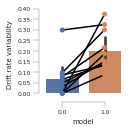

In [65]:
fig = plt.figure(figsize=(2,2))
sns.barplot(x='model', y='value', units='subj_idx', data=sv)
sns.stripplot(x='model', y='value', jitter=False, data=sv)
plt.plot(np.vstack((np.zeros(n_subjects), np.ones(n_subjects))), 
         np.vstack((sv.loc[sv['model']==0,'value'], sv.loc[sv['model']==1,'value'])),
        color='black')
plt.ylabel('Drift rate variability')
sns.despine(offset=3, trim=True)
plt.tight_layout()
fig.savefig('figs/ddm/drift_rate1.pdf')

In [59]:
# settings
n_subjects = 10
trials_per_level = 1000000/4

params = []
dcs = [-1, -0.8, -0.6, -0.4, -0.2, -0]
for dc in dcs:
    
    print(dc)

    # parameters:
    params0 = {'cond':0, 'v':1, 'a':1, 't':0.3, 'z':0.5, 'dc':dc, 'sz':0, 'st':0, 'sv':0}
    params1 = {'cond':1, 'v':1, 'a':1, 't':0.3, 'z':0.5, 'dc':0.0, 'sz':0, 'st':0, 'sv':0}

    # simulate:
    def simulate(params0, params1, trials_per_level, subj):
        df0 = simulate_data(z=params0['z'], a=params0['a'], v=params0['v'], dc=params0['dc'], 
                        t=params0['t'], sv=params0['sv'], st=params0['st'], sz=params0['sz'], 
                        condition=params0['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
        df1 = simulate_data(z=params1['z'], a=params1['a'], v=params1['v'], dc=params1['dc'], 
                            t=params1['t'], sv=params1['sv'], st=params1['st'], sz=params1['sz'], 
                            condition=params1['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
        df = pd.concat((df0, df1))
        df['subj_idx'] = subj
        return df
    df_emp = pd.concat(Parallel(n_jobs=n_subjects)(delayed(simulate)(params0, params1, trials_per_level, subj) 
                                                          for subj in range(n_subjects)))
    
    # fit chi-square:
    pars = pd.concat(Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data, depends_on=None) 
                                                          for subj, data in df_emp.groupby('subj_idx')))
    pars.drop(['bic', 'likelihood', 'penalty',], axis=1, inplace=True)
    pars['magnitude'] = dc
    params.append(pars)

-1
-0.8
-0.6
-0.4
-0.2
0


/home/jwdegee/anaconda3/envs/ddm/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


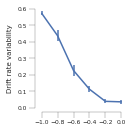

In [66]:
p = pd.concat(params)
fig = plt.figure(figsize=(2,2))
plt.errorbar(x=np.array(dcs), y=np.array(p.groupby('magnitude').mean()['sv']), yerr=np.array(p.groupby('magnitude').sem()['sv']))
plt.ylabel('Drift rate variability')
sns.despine(offset=3, trim=True)
plt.tight_layout()
fig.savefig('figs/ddm/drift_rate2.pdf')